# Analysis of Data


The overall goal of this analysis is to:
* Select features from measured variables that are most reliable to measure and predict the effect of h with.
* Create many regressions (linear, SVM, and neural networks) that can provide an accurate prediction of the heat transfer coefficient based on the key measured variables.
* Provide great visualization to see the effect and impact of these varying methods on the prediction.


The first section of the code below performs some exploratory analysis. First, we identify correlations between all the variables and present it in a 13x13 scatter plot. We also perform a variable selection method in order to get a good idea of which variables are most important to measure, as this will have implications on what variables should be measured in solar farms who want to use these regressions. 


In [1]:
#Import the various libraries and plots
import pandas as pd
import scipy as sc
import numpy as np
from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt  
from sklearn.svm import SVR

#import important keras functions
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

#Read in the prepared data

data = pd.read_csv('Final_data.csv')


/Users/Owner/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


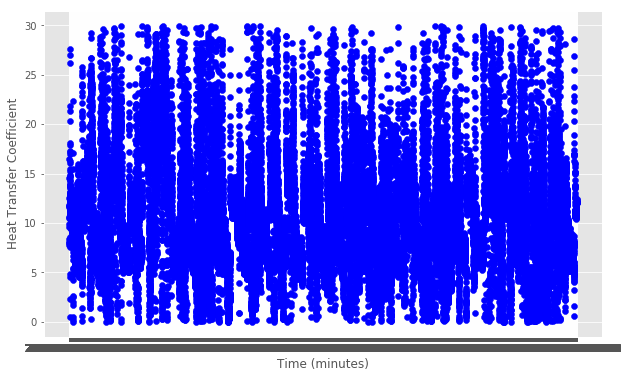

In [2]:
#This dataset has already been cleaned, but we are going to select for the most important/easily measured features.

data = data.drop(['T_Sonic_M'], axis=1)
data = data.drop(['T_Sonic_U'], axis=1)
data = data.drop(['M direction'], axis=1)
data = data.drop(['M speed'], axis=1)
data = data.drop(['U direction'], axis=1)
data = data.drop(['U speed'], axis=1)
data = data.drop(['HMP_TempC'], axis=1)
data = data.drop(['q'], axis=1)
data = data.drop(['CupWS_ms'], axis=1)
data = data.drop(['CupWD'], axis=1)
data = data.drop(['CupWD_SD'], axis=1)

#Then we will select for values of h that are reasonable (ie -8000 needs to be removed)
data = data[data.h > 0]
data = data[data.h <= 30]

#Now we can plot an example of some of the time vs h
plt.scatter(x=data['TIMESTAMP'],y=data['h'],c='b',marker='o',label='Time vs h')

plt.xlabel('Time (minutes)')
plt.ylabel('Heat Transfer Coefficient')
plt.show()

             ApogSWup  ApogSWdn  ApogLWup  ApogLWdn  CNR_SWup  CNR_SWdn  \
ApogSWup     1.000000  0.889052  0.321496  0.823982  0.939998  0.917847   
ApogSWdn     0.889052  1.000000  0.319992  0.809898  0.864170  0.884782   
ApogLWup     0.321496  0.319992  1.000000  0.651762  0.296253  0.277635   
ApogLWdn     0.823982  0.809898  0.651762  1.000000  0.784481  0.779790   
CNR_SWup     0.939998  0.864170  0.296253  0.784481  1.000000  0.986969   
CNR_SWdn     0.917847  0.884782  0.277635  0.779790  0.986969  1.000000   
CNR_LWup     0.309681  0.313176  0.922163  0.629406  0.296261  0.278963   
CNR_LWdn     0.849022  0.783984  0.579560  0.934836  0.885515  0.875471   
HMP_RH      -0.418752 -0.414503 -0.191949 -0.639067 -0.382806 -0.402155   
h            0.384851  0.436812  0.173000  0.382893  0.332532  0.350171   
L direction -0.464743 -0.457263 -0.167243 -0.423607 -0.446025 -0.442870   
L speed      0.331057  0.344418  0.320582  0.452806  0.333670  0.338611   
T_Sonic_L    0.639694  0.

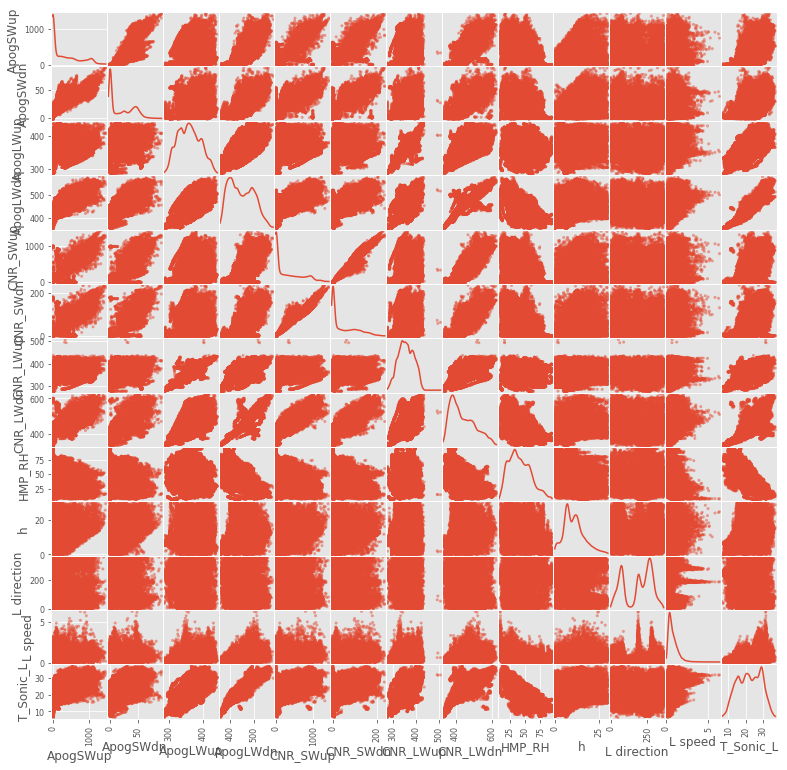

In [3]:
#Now we can display the correlations of each variable in the set along with a scatterplot
print(data.corr())
pd.plotting.scatter_matrix(data, figsize=(13, 13), diagonal='kde')
plt.show()

The most important part of the scatterplot to interpret is the last row corresponding to each variables impact on h.
<br/>

These scatterplots give us a way to intuit how each variable correlates with h, and the numerical correlation is also reported for a more comprehensible form of the effect of variables on h.
<br/>

The higher the correlation, the more important it is to measure and account for these variables because they are not accounted for in typical physical models.
<br/>

***Here we can talk about the feature selection

<br/>

Below, several different regression techniques are employed and constructed such that we can use this data set to predict h. 

# Regression Techniques


In this section, we explore the use of linear regression, SVM and SVR, Sci-kit's built in neural network, and Keras neural networks. Each one was constructed and optimized for the data set to give the maximum accuracy for prediction of h. 


# Support Vector Methods

First, we perform a classification problem where the h is split into high and low categories based on the average value, and we see if we can predict if there is high or low efficiency in a solar farm on any given conditions.

In [4]:
#Describe our h values to determine the high and low range
data.h.describe()

count    37198.000000
mean        10.946958
std          5.685280
min          0.000360
25%          6.863154
50%         10.358091
75%         14.043177
max         29.993229
Name: h, dtype: float64

In [5]:
#Here we use the average determined above to split each row into either high (1) 
#or low(0) efficiency
avg_h = 11.625416
hi_low = []
data_h = data['h']


for row in data_h:
    if row >= avg_h:
        hi_low.append(1)
    else:
        hi_low.append(0)

#So we have created a binary classifier where 1 means a high h value, and 0 is a low.
#Now we create our SVM that classifies high or low.

#First clarify which columns we are using in our data set
dataX = data.drop(['h'], axis=1)
dataX = dataX.drop(['TIMESTAMP'], axis=1)

#Define our X and y for use in the train_test_split
X = dataX
y = hi_low

#Split data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.1)

#scale the data
scaler = StandardScaler()
scaler.fit(X_train) # Fit only to the training data

# Apply scaling to X data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Define model, method, and C value. Fit to training data
model = svm.SVC(kernel = 'rbf', C=50)
model.fit(X_train,y_train)

#print confusion matrix to analyze accuracy in classification
print('Confusion Matrix:')
y_predict = model.predict(X_test)
print(metrics.confusion_matrix(y_true = y_test, y_pred = y_predict))

print('Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_predict))

Confusion Matrix:
[[2078  125]
 [ 152 1365]]
Accuracy =  0.9255376344086022


So, we can see we have succeeded in creating a fairly accurate SVM overall efficiency. This was simply classifying the h value as high and low; what about a regression where we can accurately predict the value of h?

# SVR (Regression)

In [6]:
#Now we run a SVR regression

#Define and split data again
X = dataX
y = data['h']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.1)


#scale the data
scaler = StandardScaler()
scaler.fit(X_train) # Fit only to the training data

# Apply scaling to data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#define and fit the SVR model

model = SVR(C=50.0, epsilon=0.1)
model.fit(X_train,y_train)

print('Accuracy = ', model.score(X = X_test, y = y_test))

#Rather than the built in accuracy, we can also set a performance metric by
#finding if the absolute value of the h predicted is +/- a tolerance of the 
#true h value of the test set.

#Define a tolerance
tol = 2

#Predict
y_pred_svm = model.predict(X_test)

count = 0

#calculate success
for idx, i in enumerate(y_pred_svm):
    if (abs(i - y_test.iloc[idx]) < tol):
        count += 1

#The function below calculates what percentage of our prediction was within tolerance.

Acc = round((count/len(y_pred_svm))*100,3)

print('Percent Success = ' + str(round(Acc)) + '%')

#For visualization purposes, we predict using this model for the entire data set to plot later on.


dataX_avg = scaler.transform(dataX)
svm_pred_avg = model.predict(dataX_avg)

initi = 0
counter = 1440
svmt = int(counter/2)
data_avg_svm = []
svm_time = []

while counter <= len(data):
    avg = svm_pred_avg[initi:counter]
    avg = np.mean(avg)
    data_avg_svm.append(avg)
    svm_time.append(data.TIMESTAMP.iloc[svmt])
    counter += 1440
    initi += 1440
    svmt = int(counter/2)



Accuracy =  0.7728651760654651
Percent Success = 78%


Using our condition that the h value can only vary a magnitude of 2 from the true value in the test data set, we achieve around 65% success. This is with an arbitrary C value, below is a loop that optimizes different values to maximize success of the SVM.


In [7]:
# c_val = 1
# opt_success = []
# c_val_array = []

# # while c_val < 500:
# #     model_SVR = SVR(C=c_val, epsilon=0.2)
# #     model_SVR.fit(X_train,y_train)
# #     y_pred_svm = model.predict(X_test)

# #     count2 = 0

# #     for idx, i in enumerate(y_pred_svm):
# #         if (abs(i - y_test.iloc[idx]) < 2):
# #             count2 += 1
        
# #     success = count2/len(y_pred_svm)
# #     opt_success.append(success)
# #     c_val_array.append(c_val)
# #     c_val += 50
# #     print(c_val)


# plt.scatter(x=c_val_array,y=opt_success,label='Optimal C value')

# plt.xlabel('C value')
# plt.ylabel('Percent success')
# plt.show()
    

Above is a graph of the C value plotted vs the success. From above we can store the max of the success file as below, and use this C in the future for the optimal value.

# SciKit-Learn Neural Network

Below we use a MLP regressor to predict values of h and measure the success of the network with the same tolerance method used in the SVR.

In [8]:
# MLP regression.

#Start by defining the model architecture and constants. These were varyed and optimized
#to the current values

mlp_reg = MLPRegressor(hidden_layer_sizes=(12,15,6),verbose=0,random_state=3,solver='adam', max_iter = 10000)

#fit the model to the training data
mlp_reg.fit(X_train, y_train)

#print score of the test and train to get an idea of the performance and level of fitting.

print(mlp_reg.score(X_test,y_test)) # score = 1 is good
print(mlp_reg.score(X_train,y_train)) # score = 1 is good

#Now we analyze the success with the same method as SVR.

y_pred_mlp = model.predict(X_test)

count = 0

for idx, i in enumerate(y_pred_mlp):
    if (abs(i - y_test.iloc[idx]) < tol):
        count += 1
        
Acc2 = (count/len(y_pred_mlp))*100

print('Percent Success = ' + str(round(Acc2,3)) + '%')

#Again, we use the predict function to compute averages to compare at the end.

#scale all data and predict
dataX_avg = scaler.transform(dataX)
svm_pred_sk = model.predict(dataX_avg)

initi = 0
counter = 1440
skt = int(counter/2)
data_avg_sk = []
sk_time = []

while counter <= len(data):
    avg = svm_pred_sk[initi:counter]
    avg = np.mean(avg)
    data_avg_sk.append(avg)
    sk_time.append(data.TIMESTAMP.iloc[skt])
    counter += 1440
    initi += 1440
    skt = int(counter/2)

0.7778235774163618
0.7831335658158327
Percent Success = 78.387%


Now we use Keras to see if a more sophisticated learning network is capable of producing even better results.

In [9]:
# create model with sequential and vary parameters to reach an optimal success rate.
kmodel = Sequential()
kmodel.add(Dense(20, kernel_initializer='normal', activation='relu', input_dim=12))
kmodel.add(Dense(10, activation='tanh'))
kmodel.add(Dropout(0.1))
kmodel.add(Dense(1, activation='relu'))

kmodel.summary()

kmodel.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                260       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [10]:
#Define the data to be used

X = dataX
y = data['h']

#Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.1)

# Apply scaling to data
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Fit the keras model
keras_model = kmodel.fit(X_train, y_train,
                    batch_size=10,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, y_test))


Train on 33478 samples, validate on 3720 samples
Epoch 1/10
33478/33478 [==============================] - 6s 191us/step - loss: 36.3598 - acc: 0.0000e+00 - val_loss: 19.0614 - val_acc: 0.0000e+00
Epoch 2/10
33478/33478 [==============================] - 6s 194us/step - loss: 15.7464 - acc: 0.0000e+00 - val_loss: 11.8975 - val_acc: 0.0000e+00
Epoch 3/10
33478/33478 [==============================] - 6s 191us/step - loss: 12.8681 - acc: 0.0000e+00 - val_loss: 10.8358 - val_acc: 0.0000e+00
Epoch 4/10
33478/33478 [==============================] - 7s 206us/step - loss: 12.2004 - acc: 0.0000e+00 - val_loss: 10.1822 - val_acc: 0.0000e+00
Epoch 5/10
33478/33478 [==============================] - 8s 225us/step - loss: 11.6407 - acc: 0.0000e+00 - val_loss: 9.9137 - val_acc: 0.0000e+00
Epoch 6/10
33478/33478 [==============================] - 8s 241us/step - loss: 11.2826 - acc: 0.0000e+00 - val_loss: 9.7674 - val_acc: 0.0000e+00
Epoch 7/10
33478/33478 [==============================] - 6s 191u

In [11]:
#Evaluate the success of prediction for keras.

y_pred = kmodel.predict(X_test)

count = 0

for idx, i in enumerate(y_pred):
    if (abs(i - y_test.iloc[idx]) < tol):
        count += 1
        
Acc3 = (count/len(y_pred))*100

print('Percent Success = ' + str(round(Acc3,3)) + '%')

#Now we create the pred to compare the averages

#scale all data and predict

dataX_avg = scaler.transform(dataX)
svm_pred_k = kmodel.predict(dataX_avg)

initi = 0
counter = 1440
kt = int(counter/2)
data_avg_k = []
k_time = []

while counter <= len(data):
    avg = svm_pred_k[initi:counter]
    avg = np.mean(avg)
    data_avg_k.append(avg)
    k_time.append(data.TIMESTAMP.iloc[kt])
    counter += 1440
    initi += 1440
    kt = int(counter/2)




Percent Success = 63.629%


# Results


Now that we have successes for each method and they have been optimized, we can create averages of the weeks for the real data and plot it over the predicted averages per week to obtain a visualization of how well each method is performing. We can also construct a simple table to numerically compare the success of each method.

In [12]:
#Create true data averages of h

len(data)

37198

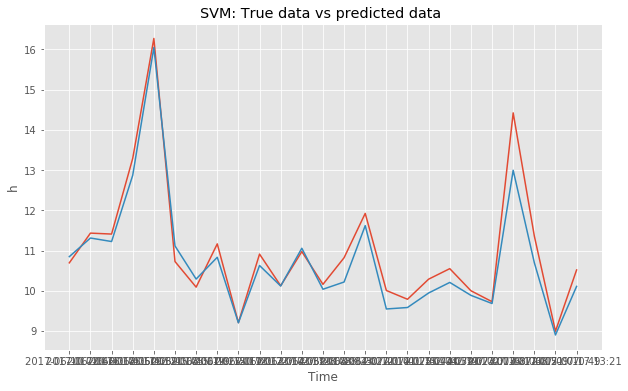

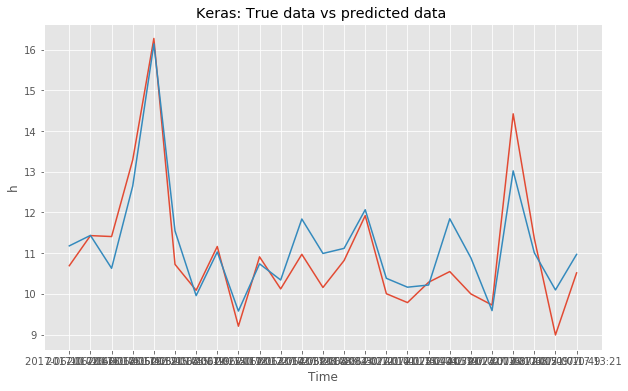

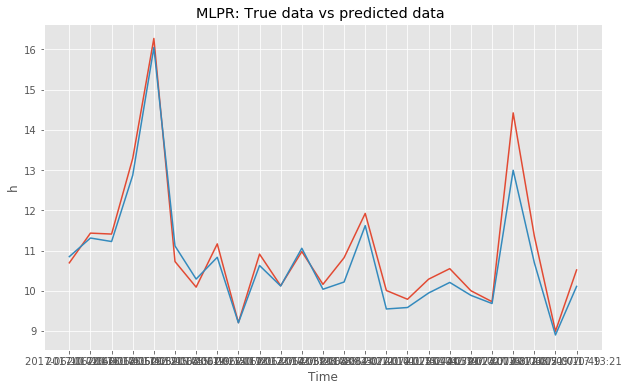

In [13]:
#Initialize for the daily averages calculations
initi = 0
counter = 1440
time_stamp = int(counter/2)
data_avg = []
time_array = []

#loop finds the average over every 1440 minutes and saves the rough date with the avg
while counter <= len(data):
    avg = data[initi:counter]
    avg = avg.h
    avg = np.mean(avg)
    data_avg.append(avg)
    time_array.append(data.TIMESTAMP.iloc[time_stamp])
    counter += 1440
    initi += 1440
    time_stamp = int(counter/2)

#Plot the true average over the predicted average
plt.plot(time_array,data_avg)
plt.plot(svm_time,data_avg_svm)
plt.title('SVM: True data vs predicted data ')
plt.xlabel('Time')
plt.ylabel('h')
plt.legend()
plt.show()

plt.plot(time_array,data_avg)
plt.plot(k_time,data_avg_k)
plt.title('Keras: True data vs predicted data ')
plt.xlabel('Time')
plt.ylabel('h')
plt.legend()
plt.show()

plt.plot(time_array,data_avg)
plt.plot(sk_time,data_avg_sk)
plt.title('MLPR: True data vs predicted data ')
plt.xlabel('Time')
plt.ylabel('h')
plt.legend()
plt.show()

In [14]:
Accs = [Acc, Acc2, Acc3]

labels = ['SVM Reg', 'MLP Reg', 'Keras']
table = pd.DataFrame(data = Accs).transpose()

table.columns = [labels]
print(table.to_string(index=False))

SVM Reg    MLP Reg      Keras
 78.387  78.387097  63.629032
